In [ ]:
# Import Required Libraries
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from google.colab import files  # For saving files to left panel
import shutil
from PIL import Image

# UPLOAD AND EXTRACT DATASET IN GOOGLE COLAB
print("Please upload the 'NNmimipro1_data_thresh' folder as a ZIP file.")
uploaded = files.upload()  # User uploads ZIP

# Extract the uploaded ZIP file
for filename in uploaded.keys():
    shutil.unpack_archive(filename, "/content/")

# Define Dataset Paths for Google Colab
DATASET_PATH = "/content/NNmimipro1_data_thresh"
TRAIN_PATH = os.path.join(DATASET_PATH, "NNminipro1_train_aug")
TEST_PATH = os.path.join(DATASET_PATH, "NNminipro1_test_aug")

# === USE GOOGLE COLAB GPU === #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Please upload the 'NNmimipro1_data_thresh' folder as a ZIP file.


Saving NNmimipro1_data_thresh.zip to NNmimipro1_data_thresh.zip
Using device: cuda


Epoch [1/20], Loss: 0.1020, Train Accuracy: 0.8512
Epoch [2/20], Loss: 0.0684, Train Accuracy: 0.9032
Epoch [3/20], Loss: 0.0551, Train Accuracy: 0.9226
Epoch [4/20], Loss: 0.0488, Train Accuracy: 0.9317
Epoch [5/20], Loss: 0.0450, Train Accuracy: 0.9371
Epoch [6/20], Loss: 0.0425, Train Accuracy: 0.9407
Epoch [7/20], Loss: 0.0405, Train Accuracy: 0.9436
Epoch [8/20], Loss: 0.0388, Train Accuracy: 0.9460
Epoch [9/20], Loss: 0.0373, Train Accuracy: 0.9482
Epoch [10/20], Loss: 0.0359, Train Accuracy: 0.9502
Epoch [11/20], Loss: 0.0347, Train Accuracy: 0.9519
Epoch [12/20], Loss: 0.0336, Train Accuracy: 0.9534
Epoch [13/20], Loss: 0.0328, Train Accuracy: 0.9546
Epoch [14/20], Loss: 0.0320, Train Accuracy: 0.9557
Epoch [15/20], Loss: 0.0313, Train Accuracy: 0.9567
Epoch [16/20], Loss: 0.0307, Train Accuracy: 0.9576
Epoch [17/20], Loss: 0.0301, Train Accuracy: 0.9584
Epoch [18/20], Loss: 0.0295, Train Accuracy: 0.9593
Epoch [19/20], Loss: 0.0290, Train Accuracy: 0.9599
Epoch [20/20], Loss: 

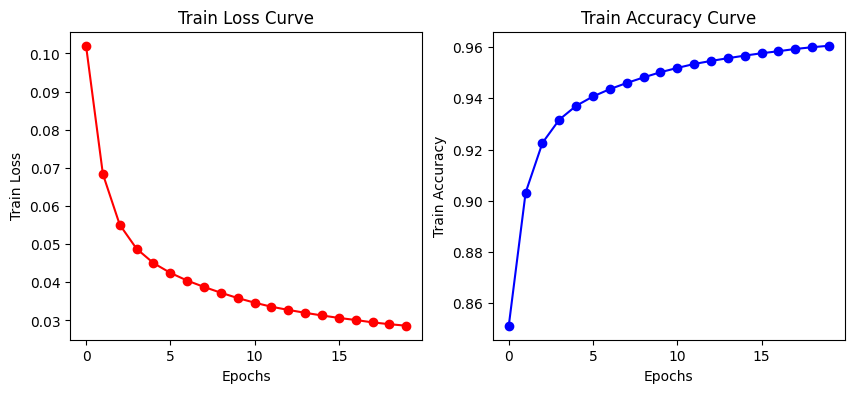

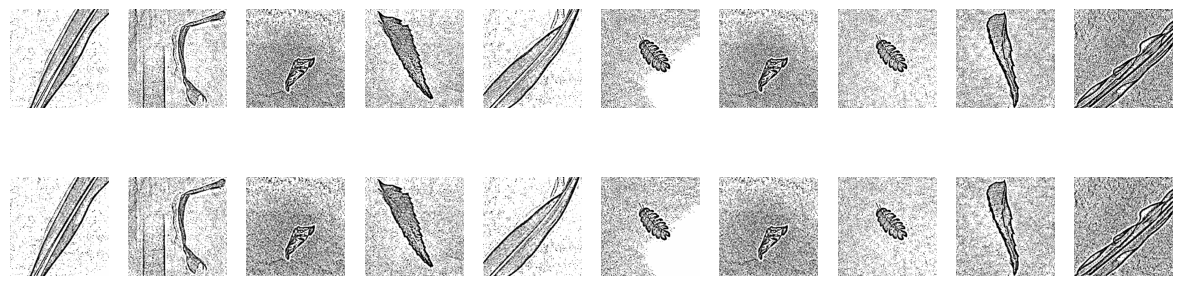

Test MSE: 0.026490
Test Accuracy: 0.9735
Training & Testing Completed!


In [ ]:
# Define Transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to single-channel grayscale
    transforms.ToTensor(),  # Convert to tensor
])

# Custom Dataset Class
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []

        # Collect all image paths
        for species_folder in os.listdir(root_dir):
            species_path = os.path.join(root_dir, species_folder)
            if os.path.isdir(species_path):
                for img_file in os.listdir(species_path):
                    img_path = os.path.join(species_path, img_file)
                    self.image_paths.append(img_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        try:
            img = Image.open(img_path).convert("L")  # Force grayscale conversion
        except Exception as e:
            print(f"Warning: Could not load {img_path} - {e}")
            return None

        if self.transform:
            img = self.transform(img)

        return img

# Create Datasets & Loaders
train_dataset = ImageDataset(TRAIN_PATH, transform=transform)
test_dataset = ImageDataset(TEST_PATH, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=2, pin_memory=True)

# Define Deep Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize Model, Loss, and Optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 20
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_pixels = 0
    total_pixels = 0

    for images in train_loader:
        images = images.to(device)  # Ensure grayscale shape is correct
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Compute pixel-wise accuracy (binary match of reconstructed vs original)
        threshold = 0.5  # Threshold for binarization
        correct_pixels += torch.sum((outputs > threshold) == (images > threshold)).item()
        total_pixels += images.numel()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Calculate Train Accuracy
    train_accuracy = correct_pixels / total_pixels
    train_accuracies.append(train_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

# Plot Train Loss and Accuracy Curves
plt.figure(figsize=(10, 4))

# Train Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, marker='o', color='red')
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.title("Train Loss Curve")

# Train Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, marker='o', color='blue')
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy Curve")

plt.show()

# Reconstruct 10 Random Test Images
model.eval()
random_indices = np.random.choice(len(test_dataset), 10, replace=False)
random_images = torch.stack([test_dataset[i] for i in random_indices])
random_images = random_images.to(device)
reconstructed_images = model(random_images).cpu().detach().numpy()

fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    axes[0, i].imshow(random_images[i].cpu().squeeze(), cmap='gray')
    axes[0, i].axis("off")
    axes[1, i].imshow(reconstructed_images[i].squeeze(), cmap='gray')
    axes[1, i].axis("off")

plt.show()

# Compute Test MSE & Test Accuracy
total_mse = 0
num_batches = 0  # To track the number of batches

for images in test_loader:
    images = images.to(device)
    outputs = model(images)

    mse = criterion(outputs, images).item()  # Compute Mean Squared Error for this batch
    total_mse += mse
    num_batches += 1  # Count the number of batches

# Calculate average test MSE
test_mse = total_mse / num_batches  # Divide total MSE by number of batches
print(f"Test MSE: {test_mse:.6f}")

# Compute Test Accuracy
max_mse = 1.0  # Assuming pixel values are normalized between 0 and 1
test_accuracy = 1 - (test_mse / max_mse)

print(f"Test Accuracy: {test_accuracy:.4f}")

print("Training & Testing Completed!")

In [ ]:
import torch
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define paths to save model
local_model_path = "/content/autoencoder_model_27mar.pth"  # Local path in Colab
drive_model_path = "/content/drive/MyDrive/autoencoder_model_27mar.pth"  # Save in Google Drive

# Save the trained model locally
torch.save(model.state_dict(), local_model_path)
print(f"Model saved locally at: {local_model_path}")

# Copy the model to Google Drive
!cp {local_model_path} {drive_model_path}
print(f"Model also saved in Google Drive at: {drive_model_path}")


Mounted at /content/drive
Model saved locally at: /content/autoencoder_model_27mar.pth
Model also saved in Google Drive at: /content/drive/MyDrive/autoencoder_model_27mar.pth
